# Tutorial to DASStore client
- SeaDAS with Zarr backend
- Yiyu Ni (Feb 23, 2023)
- Project repository: https://github.com/niyiyu/DASStore

In [1]:
import sys
sys.path.append("../")
from dasstore.zarr import Client

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## client class
A `Client` class can be instantiated to access a specific DASSttore dataset. Users would specify the `bucket_name` and the `endpoint_url` of the object storage. Here, I store one month of SeaDAS data in the `SeaDAS` bucket in an object storage running at port `9000` of a local server. 

Users could public their data set through the `Min.IO` console. But the bucket we are using here does not allow public access, so I set `anon = False` (default) and have an access `key/secure` pair for authentication (a credential). The key pair is stored in `~/.dasstore/credential` (may change in the future):
```
$ cat ~/.dasstore/credentials
aws_access_key_id = ACCESS_KEY_ID
aws_secret_access_key = ACCESS_KEY_SECRET
```

In [2]:
client = Client("SeaDAS", "pnwstore1.ess.washington.edu:9000", anon = False)
client

Bucket:    	 s3://SeaDAS 
Anonymous: 	 False 
Exist:     	 True 
Endpoint:  	 http://pnwstore1.ess.washington.edu:9000
Backend:   	 Zarr


## metadata
Users could get the metadata by accssing the `meta` attribute of the client. I follow the metadata convension defined in https://github.com/DAS-RCN/DAS_metadata. There are five levels of metadata: `Overview`, `Cable and Fiber`, `Interrogator`, `Acquisition`, and `Channel`. The `Channel` level metadata is still missing and needs more development.

In [3]:
client.meta

{'_ARRAY_DIMENSIONS': ['channel', 'time'],
 'acquisition.acquisition_end_time': '2022-12-31T23:59:59.990000',
 'acquisition.acquisition_id': 'N/A',
 'acquisition.acquisition_sample_rate': 100,
 'acquisition.acquisition_start_time': '2022-12-01T00:00:00.000000',
 'acquisition.archived_sample_rate': 'N/A',
 'acquisition.channel_spacing': 'N/A',
 'acquisition.comment': 'N/A',
 'acquisition.decimation': 'N/A',
 'acquisition.filtering': 'N/A',
 'acquisition.gauge_length': 'N/A',
 'acquisition.interrogator_rate': 'N/A',
 'acquisition.number_of_channels': 'N/A',
 'acquisition.pulse_repetition_rate': 'N/A',
 'acquisition.pulse_width': 'N/A',
 'acquisition.unit_of_measure': 'N/A',
 'cable_and_fiber.attenuation': 'N/A',
 'cable_and_fiber.cable_characteristics': 'N/A',
 'cable_and_fiber.cable_connector_coordinates': 'N/A',
 'cable_and_fiber.cable_coordinates': 'N/A',
 'cable_and_fiber.cable_diameter': 'N/A',
 'cable_and_fiber.cable_end_time': 'N/A',
 'cable_and_fiber.cable_environment': 'N/A',
 '

## client.get_data(channel_index, starttime, endtime)
The `get_data` function of the client can be used to get the raw DAS data. The channel index can be either an integer (single channel) or an array (multiple channels). The `starttime` and `endtime` are just the string UTC time.

When converting DAS data into the DASStore, users can specify the fill value (Not-a-Number, NaN in this case). This feature is useful in showing data gaps (or any potential issue that affected the writing).

**Note:** as Zarr chunks DAS data (1 minute, 50 channels in this case), it's recommended to request multiple channels at the same time, instead of sequentially request single channel. Remember that for Zarr, always **the whole data chunk** is being requested and received, although you may not want them.


Query time:	1.410 second
Data shape:	 (360000,)


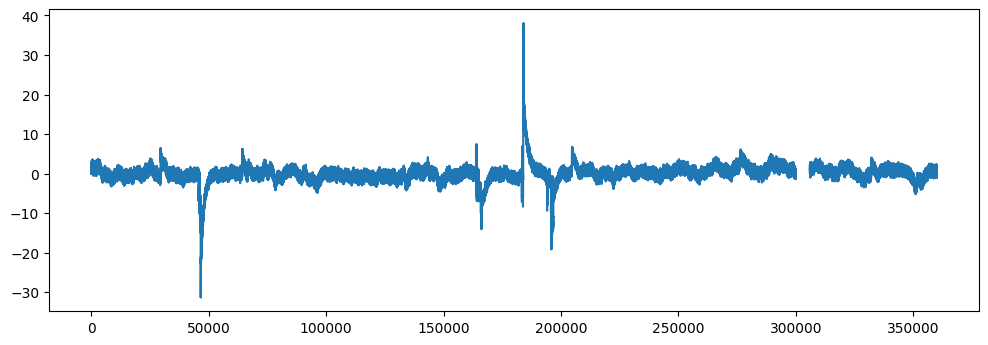

In [4]:
# get one hour data of channel index 1
# note that index starts from 1 (Python convension)
t0 = time.time()
data = client.get_data(1, 
                       starttime = "2022-12-01T10:00:00.000", 
                       endtime = "2022-12-01T11:00:00.000")

print("Query time:\t%.3f second" % (time.time() - t0))
print(f"Data shape:\t {data.shape}")

plt.figure(figsize = (12, 4), dpi = 100)
plt.plot(data)

# note the data gap around t = 300000 (50 minutes after the starttime)

Query time: 2.809 second
Data shape:	 (32, 360000)


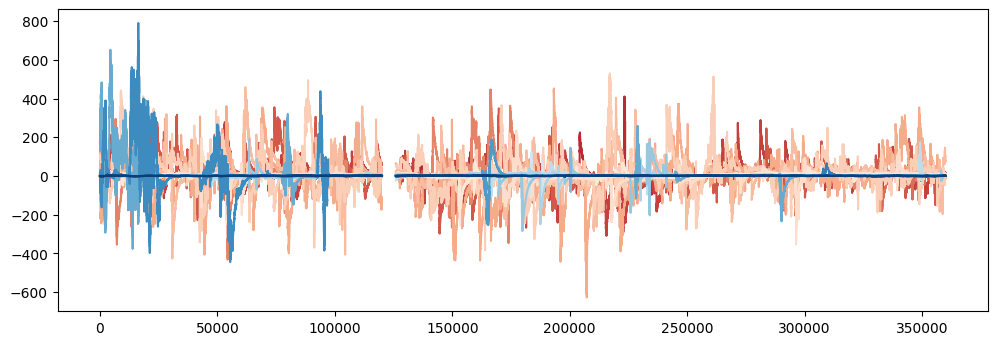

In [5]:
# get half-hour data of channel index 20 to 52

t0 = time.time()
data = client.get_data(np.arange(20, 52), 
                       starttime = "2022-12-01T10:30:00.000", 
                       endtime = "2022-12-01T11:30:00.000")
print("Query time: %.3f second" % (time.time() - t0))
print(f"Data shape:\t {data.shape}")

plt.figure(figsize = (12, 4), dpi = 100)
for i in range(32):
    plt.plot(data[i, :], color = cm.RdBu(i*8))
    
# note the data gap for all channels.

## EOF